## Restoration Result

In [1]:
import os
import torch
import pickle
import plotly.io as pio
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import linregress
renderer = "jupyterlab"
pio.renderers.default = renderer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [2]:
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(tensor.numpy(), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=tensor.numpy(), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = x.numpy()
    y = y.numpy()
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

def save_pickle(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

# Function to load a pickle object from a file
def load_pickle(filename):
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    return obj

## Load Results

In [3]:
def flatten_all_results():
    pickle_files = [f for f in os.listdir("results") if f.split(".")[-1]=="pickle"]
    pickle_files = [f for f in pickle_files if "restoration" in f]
    results = []
    for file in pickle_files: 
        results += load_pickle("results/" + file)
        
    results_dict = {}
    for d in results: 
        for k,v in d.items(): 
            results_dict.setdefault(k, []).append(v)
            
    return results_dict

        
results = flatten_all_results()

In [5]:
list(results.keys())

['layer_names',
 'clean_mle_residual_logits',
 'clean_target_residual_logits',
 'corrupted_mle_residual_logits',
 'corrupted_target_residual_logits',
 'ablated_mle_residual_logits',
 'ablated_target_residual_logits',
 'total_ablated_mle_logits',
 'total_ablated_target_logits',
 'clean_mle_logit',
 'clean_target_logit',
 'corrupted_mle_logit',
 'corrupted_target_logit',
 'total_ablated_mle_position_logits',
 'total_ablated_target_position_logits',
 'total_ablated_mle_residual_position_logits',
 'total_ablated_target_residual_position_logits',
 'prompt',
 'subject_mask']

In [6]:
layer_names = results["layer_names"][0]
clean_mle_residual_logits = torch.stack(results["clean_mle_residual_logits"])
clean_target_residual_logits = torch.stack(results["clean_target_residual_logits"])
corrupted_mle_residual_logits = torch.stack(results["corrupted_mle_residual_logits"])
corrupted_target_residual_logits = torch.stack(results["corrupted_target_residual_logits"])
ablated_mle_residual_logits = torch.stack(results["ablated_mle_residual_logits"])
ablated_target_residual_logits = torch.stack(results["ablated_target_residual_logits"])
total_ablated_mle_logits = torch.stack(results["total_ablated_mle_logits"])
total_ablated_target_logits = torch.stack(results["total_ablated_target_logits"])
clean_mle_logit = torch.stack(results["clean_mle_logit"])
clean_target_logit = torch.stack(results["clean_target_logit"])
corrupted_mle_logit = torch.stack(results["corrupted_mle_logit"])
corrupted_target_logit = torch.stack(results["corrupted_target_logit"])

prompts = results["prompt"]
total_ablated_mle_position_logits = results["total_ablated_mle_position_logits"]
total_ablated_target_position_logits = results["total_ablated_target_position_logits"]
total_ablated_mle_residual_position_logits = results["total_ablated_mle_residual_position_logits"]
total_ablated_target_residual_position_logits = results["total_ablated_target_residual_position_logits"]
subject_mask = results["subject_mask"]

results = {
    "layer_names": layer_names,
    "clean_mle_residual_logits": clean_mle_residual_logits,
    "clean_target_residual_logits": clean_target_residual_logits,
    "corrupted_mle_residual_logits": corrupted_mle_residual_logits,
    "corrupted_target_residual_logits": corrupted_target_residual_logits,
    "ablated_mle_residual_logits": ablated_mle_residual_logits,
    "ablated_target_residual_logits": ablated_target_residual_logits,
    "total_ablated_mle_logits": total_ablated_mle_logits,
    "total_ablated_target_logits": total_ablated_target_logits,
    "clean_mle_logit": clean_mle_logit,
    "clean_target_logit": clean_target_logit,
    "corrupted_mle_logit": corrupted_mle_logit,
    "corrupted_target_logit": corrupted_target_logit,
    "total_ablated_mle_position_logits":total_ablated_mle_position_logits,
    "total_ablated_target_position_logits":total_ablated_target_position_logits,
    "total_ablated_mle_residual_position_logits":total_ablated_mle_residual_position_logits,
    "total_ablated_target_residual_position_logits":total_ablated_target_residual_position_logits,
    "subject_mask":subject_mask,
    "prompts":prompts,
}

Given a corrupted prompt, we patch in the activations from the clean prompt. 

In [17]:
def plot_total_effect(results, title, ablated="all", view_effect="all", logit="mle"):
    """
    Output logit with ablation - output logit without ablation
    """
    if ablated=="all":
        ablated="_"
    if view_effect=="all":
        view_effect="_"
        
    layer_names = results["layer_names"]
    effect_mask = torch.tensor([view_effect in layer_name for layer_name in layer_names])
    effect_mask = effect_mask[2:]
                       
    if logit=="mle":
        clean_final_logit = results["corrupted_mle_logit"]
        ablated_final_logits = results["total_ablated_mle_logits"]                           
    elif logit=="target":
        clean_final_logit = results["corrupted_target_logit"]
        ablated_final_logits = results["total_ablated_target_logits"]
        
    ablated_final_logits = ablated_final_logits[:, effect_mask]
    
    total_effect = (ablated_final_logits - clean_final_logit)
    total_effect_mean = (total_effect.mean(dim=0))
    
    
    fig = plt.figure(figsize=(5, 3))
    for te in total_effect: 
        plt.plot(te, color="lightgrey")
    plt.plot(total_effect_mean, color="blue", label="Mean")
    
    if ablated=="attn":
        xlabel = "Ablated Attention Output"
    elif ablated=="mlp":
        xlabel = "Ablated MLP Output"
    elif ablated=="_":
        xlabel = "Ablated Attention + MLP Output"
    
    if logit=="mle":
        ylabel = "MLE Logit"
    elif logit=="target":
        ylabel = "Target Logit"
    
    plt.title(title)
    plt.ylabel(f"Total Effect on {ylabel}")
    plt.xlabel(xlabel)
    
    plt.show()


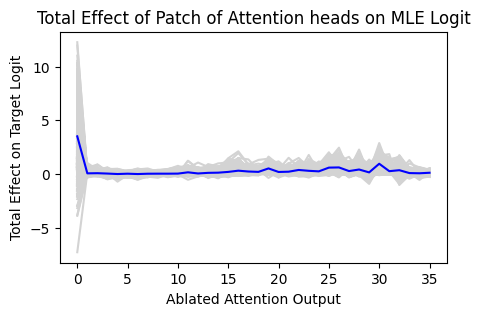

In [21]:
plot_total_effect(results, title="Total Effect of Patch of Attention heads on MLE Logit", 
                   ablated="attn", view_effect="attn", logit="target")

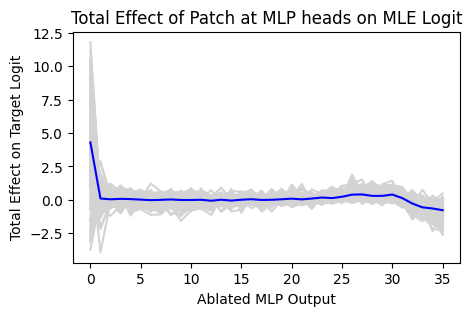

In [20]:
plot_total_effect(results, title="Total Effect of Patch at MLP heads on MLE Logit", 
                   ablated="mlp", view_effect="mlp", logit="target")

In [22]:
list(results.keys())

['layer_names',
 'clean_mle_residual_logits',
 'clean_target_residual_logits',
 'corrupted_mle_residual_logits',
 'corrupted_target_residual_logits',
 'ablated_mle_residual_logits',
 'ablated_target_residual_logits',
 'total_ablated_mle_logits',
 'total_ablated_target_logits',
 'clean_mle_logit',
 'clean_target_logit',
 'corrupted_mle_logit',
 'corrupted_target_logit',
 'total_ablated_mle_position_logits',
 'total_ablated_target_position_logits',
 'total_ablated_mle_residual_position_logits',
 'total_ablated_target_residual_position_logits',
 'subject_mask',
 'prompts']

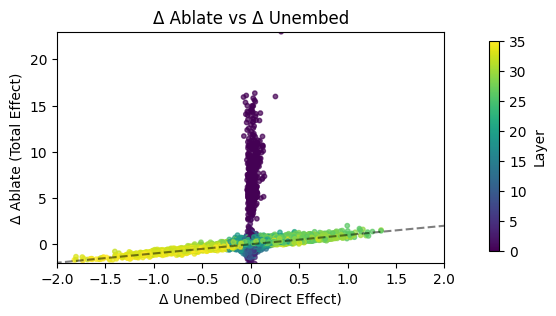

In [50]:
def plot_delta_ablate_vs_delta_unembed(results, title, logit="mle", ablated="all", view_effect="all", use_direct_effect=False):
    if ablated=="all":
        ablated="_"
    if view_effect=="all":
        view_effect="_"
        
    layer_names = results["layer_names"]
    effect_mask = torch.tensor([view_effect in layer_name for layer_name in layer_names])
    effect_mask = effect_mask[2:]
                       
    if logit=="mle":
        ablated_residual_logits = results["ablated_mle_residual_logits"]
        clean_residual = results["corrupted_mle_residual_logits"]
        ablated_final_logits = results["total_ablated_mle_logits"]
        clean_final_logit = results["corrupted_mle_logit"]

    elif logit=="target":
        ablated_residual_logits = results["ablated_target_residual_logits"]
        clean_residual = results["corrupted_target_residual_logits"]
        ablated_final_logits = results["total_ablated_target_logits"]
        clean_final_logit = results["corrupted_target_logit"]
    
    batch, ablation_idx, effect_idx = ablated_residual_logits.shape
    clean_residual = clean_residual[:,2:]
    ablated_residual_logits = ablated_residual_logits[:, :, 2:]
    
    delta_unembed = torch.zeros((batch, clean_residual.shape[-1]))
    for i in range(batch):
        delta_unembed[i] = torch.diagonal(ablated_residual_logits[i])
        
    if use_direct_effect: 
        delta_unembed = delta_unembed - clean_residual
    
    delta_ablate = ablated_final_logits - clean_final_logit
    
    delta_ablate = delta_ablate[:, effect_mask]
    delta_unembed = delta_unembed[:, effect_mask]

    #plotting
    fig = plt.figure(figsize=(5, 3))
    for i in range(batch): 
        x = delta_unembed[i]
        y = delta_ablate[i]
        layer_colors = plt.cm.viridis(np.linspace(0, 1, x.shape[-1]))
        plt.scatter(x = x, y = y, c=layer_colors, s=10, marker='o', alpha=0.7)
        
    min_val = min(delta_unembed.min(), delta_ablate.min())
    max_val = max(delta_unembed.max(), delta_ablate.max())
    
    plt.ylabel("Δ Ablate (Total Effect)")
    plt.xlabel("Δ Unembed (Direct Effect)")
    
    magnitude_axis=2
    plt.xlim(-magnitude_axis, magnitude_axis)
    plt.ylim(-magnitude_axis, max_val)

    # Set the limits for the dashed line to go through zero and extend on both sides
    line_min = min(min_val, 0)
    line_max = max(max_val, 0)
    plt.plot([line_min, line_max], [line_min, line_max], color='black', linestyle='dashed', alpha=0.5)
    plt.title(title)
    cax = fig.add_axes([0.99, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), cax=cax)
    tick_locations = np.linspace(0, 1, 8)  # Adjust the number of ticks as needed
    tick_labels = np.arange(0, 36, 5)
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)
    cbar.set_label('Layer')
    plt.show()

    
plot_delta_ablate_vs_delta_unembed(results, title="Δ Ablate vs Δ Unembed", 
                                   logit="mle", ablated="mlp", view_effect="mlp", use_direct_effect=True)

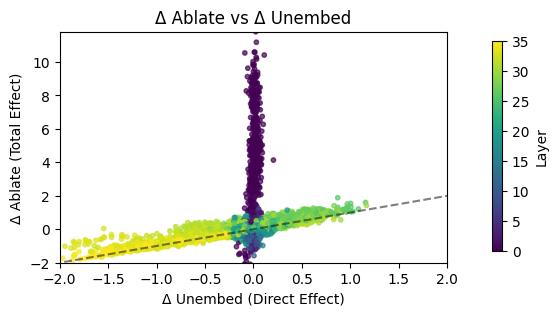

In [28]:
plot_delta_ablate_vs_delta_unembed(results, title="Δ Ablate vs Δ Unembed", 
                                   logit="target", ablated="attn", view_effect="mlp", use_direct_effect=True)

In [30]:
list(results.keys())

['layer_names',
 'clean_mle_residual_logits',
 'clean_target_residual_logits',
 'corrupted_mle_residual_logits',
 'corrupted_target_residual_logits',
 'ablated_mle_residual_logits',
 'ablated_target_residual_logits',
 'total_ablated_mle_logits',
 'total_ablated_target_logits',
 'clean_mle_logit',
 'clean_target_logit',
 'corrupted_mle_logit',
 'corrupted_target_logit',
 'total_ablated_mle_position_logits',
 'total_ablated_target_position_logits',
 'total_ablated_mle_residual_position_logits',
 'total_ablated_target_residual_position_logits',
 'subject_mask',
 'prompts']

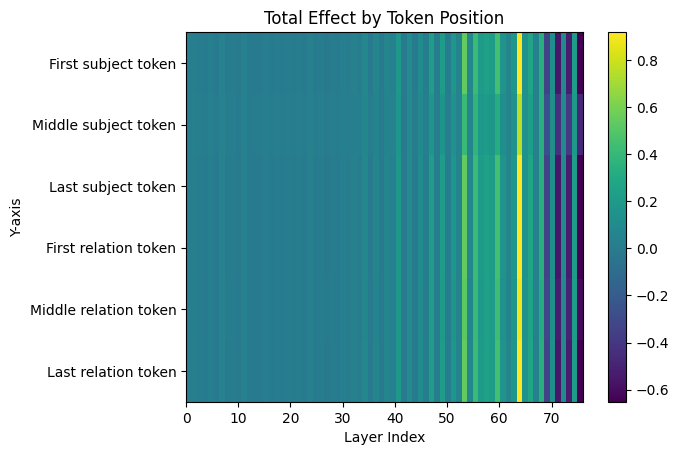

In [129]:
def total_effect_by_token_position(results, title, logit="mle", ablated="all", view_effect="all", use_direct_effect=False):
    if ablated=="all":
        ablated="_"
    if view_effect=="all":
        view_effect="_"
        
    layer_names = results["layer_names"]
    effect_mask = torch.tensor([view_effect in layer_name for layer_name in layer_names])
    effect_mask = effect_mask[2:]
    subject_masks = results["subject_mask"]
    n_experiments = len(subject_masks)
    
    if logit=="mle":
        total_ablated_position_logits = results["total_ablated_mle_position_logits"]
        total_ablated_residual_position_logits = results["total_ablated_mle_residual_position_logits"]
        total_corrupted_residual_logits = results["corrupted_mle_residual_logits"]
        total_ablated_residual_logits = results["ablated_mle_residual_logits"]
        total_ablated_logits = results["total_ablated_mle_logits"]
        total_corrupted_logit = results["corrupted_mle_logit"]
    else: 
        total_ablated_position_logits = results["total_ablated_target_position_logits"]
        total_ablated_residual_position_logits = results["total_ablated_target_residual_position_logits"]
        total_corrupted_residual_logits = results["corrupted_target_residual_logits"]
        total_ablated_residual_logits = results["ablated_target_residual_logits"]
        total_ablated_logits = results["total_ablated_target_logits"]
        total_corrupted_logit = results["corrupted_target_logit"]
    
    total_effect_positions = []
    
    for i in range(n_experiments):
        ablated_residual_position_logits = total_ablated_residual_position_logits[i]
        corrupted_residual_logits = total_corrupted_residual_logits[i]
        ablated_residual_position_logits = ablated_residual_position_logits[:,:,2:]
        corrupted_residual_logits = corrupted_residual_logits[2:]
        ablated_residual_position_logits = ablated_residual_position_logits.transpose(1,0)
        
        direct_effect = torch.diagonal(ablated_residual_position_logits, dim1=1, dim2=2)
        direct_effect = direct_effect - corrupted_residual_logits
        
        # ablated_position_logits = total_ablated_position_logits[i]
        # ablated_residual_position_logits = total_ablated_residual_position_logits[i]
        # ablated_residual_position_logits = ablated_residual_position_logits[:,:,2]
        # ablated_logits = total_ablated_logits[i]
        # corrupted_logit = total_corrupted_logit[i]
        # total_effect = ablated_position_logits - corrupted_logit.item()
        
        total_effect = direct_effect.T
        
        subject_mask = subject_masks[i]
        subject_idx = torch.nonzero(subject_mask.squeeze()).squeeze()
        if subject_mask.sum() < 2:
            continue
        relation_idx = torch.arange(subject_idx[-1]+1, subject_mask.shape[-1])
        
        if relation_idx.shape[-1] < 2:
            continue
        
        if subject_mask.sum() == 2:
            first_subject_idx = subject_idx[0]
            middle_subject_idx = subject_idx[0]
            last_subject_idx = subject_idx[1]
        else: 
            first_subject_idx = subject_idx[0]  
            middle_subject_idx = subject_idx[1:-1]
            last_subject_idx = subject_idx[-1]
            
        if relation_idx.shape[-1] == 2:
            first_relation_idx = relation_idx[0]
            middle_relation_idx = relation_idx[0]
            last_relation_idx = relation_idx[1]
        else:
            first_relation_idx = relation_idx[0]
            middle_relation_idx = relation_idx[1:-1]
            last_relation_idx = relation_idx[-1]
            
        total_effect_pos = torch.zeros((72, 6))
        total_effect_pos[:,0] = total_effect[:, first_subject_idx]
        total_effect_pos[:,1] = total_effect[:, middle_subject_idx].mean(dim=-1)
        total_effect_pos[:,2] = total_effect[:, last_subject_idx]
        total_effect_pos[:,3] = total_effect[:, first_relation_idx]
        total_effect_pos[:,4] = total_effect[:, middle_relation_idx].mean(dim=-1)
        total_effect_pos[:,5] = total_effect[:, last_relation_idx]
        total_effect_positions.append(total_effect_pos)
        
    total_effect_positions = torch.stack(total_effect_positions, dim=0)
    total_effect_positions = total_effect_positions.mean(dim=0)

    total_effect_positions = total_effect_positions[effect_mask, :]
    total_effect_positions = total_effect_positions.T
    
    plt.imshow(
        total_effect_positions,
        cmap='viridis',
        interpolation='nearest', 
        aspect='auto',
        extent=[0, 76, 0, 6],
    )
    
    y_tick_labels = ['First subject token', 'Middle subject token', 'Last subject token', 
                     'First relation token', 'Middle relation token', 'Last relation token']
    plt.yticks(np.arange(0.5, 6.5), y_tick_labels[::-1]) 

    plt.colorbar()
    plt.xlabel('Layer Index')
    plt.ylabel('Y-axis')
    plt.title(title)
    plt.show()
    
total_effect_by_token_position(results,
                               title="Total Effect by Token Position", 
                               logit="target",
                               ablated="all",
                               view_effect="all")

In [41]:
a = torch.tensor([[False,  True,  True,  True,  True,  True, False, False, False, False,
          False]])

a

tensor([1, 2, 3, 4, 5])

In [32]:
results["subject_mask"]

[tensor([[False,  True,  True,  True,  True,  True, False, False, False, False,
          False]]),
 tensor([[False,  True,  True,  True,  True, False, False, False]]),
 tensor([[False, False, False, False, False, False,  True,  True,  True, False]]),
 tensor([[False,  True,  True,  True,  True, False, False, False]]),
 tensor([[False, False, False, False, False, False,  True,  True,  True,  True,
          False]]),
 tensor([[False,  True,  True, False, False, False]]),
 tensor([[False, False, False, False, False, False,  True, False]]),
 tensor([[False, False, False, False, False, False, False]]),
 tensor([[False,  True,  True,  True,  True,  True,  True, False, False, False,
          False]]),
 tensor([[False,  True,  True, False, False, False, False, False]]),
 tensor([[False,  True,  True,  True,  True,  True, False, False, False, False,
          False, False]]),
 tensor([[False,  True,  True,  True,  True, False, False, False]]),
 tensor([[False,  True,  True,  True,  True,  Tr

In [ ]:
'total_ablated_mle_position_logits',
 'total_ablated_target_position_logits',
 'total_ablated_mle_residual_position_logits',
 'total_ablated_target_residual_position_logits',
 'subject_mask'